In [1]:
import numpy as np
import os
import sys
import tensorflow as tf
import time

from glob import glob
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

/home/surya/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
model_30k = 'mobilenet_20000.pb'
PATH_TO_LABELS = 'label_map.pbtxt'
NUM_CLASSES = 4

In [3]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': 'Green'}, 2: {'id': 2, 'name': 'Red'}, 3: {'id': 3, 'name': 'Yellow'}, 4: {'id': 4, 'name': 'off'}}


In [4]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [5]:
detection_graph = tf.Graph()

with detection_graph.as_default():
    
  od_graph_def = tf.GraphDef()

  with tf.gfile.GFile(model_30k, 'rb') as fid:
        
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [6]:
PATH_TO_TEST_IMAGES_DIR = 'test_images_udacity'

print(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
TEST_IMAGE_PATHS = glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
print("Length of test images:", len(TEST_IMAGE_PATHS))

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

test_images_udacity/*.jpg
Length of test images: 9


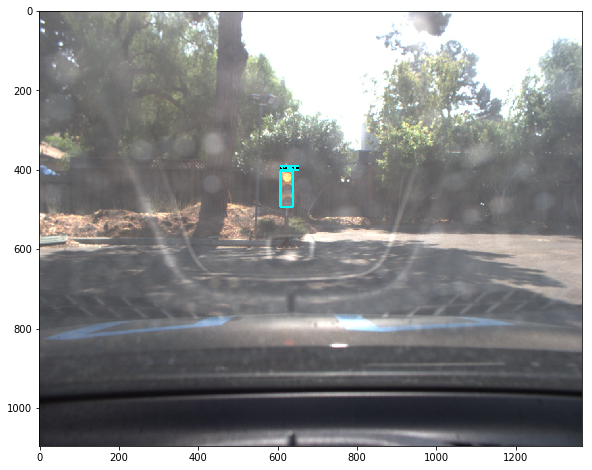

Red 0.9977151
Distance (metres) 0.0
Time in milliseconds 2583.416700363159 



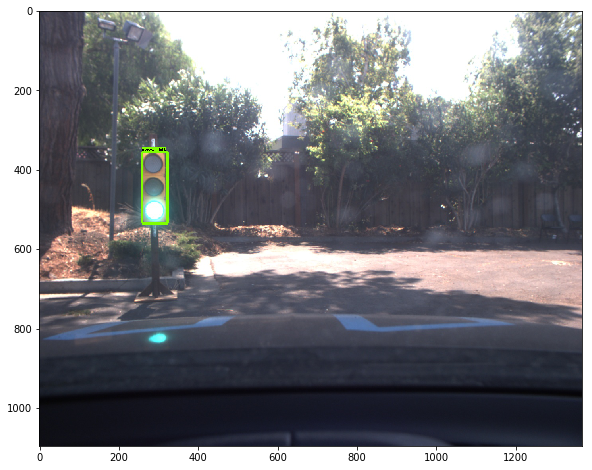

Green 0.99522346
Distance (metres) 0.0
Time in milliseconds 13.557910919189453 



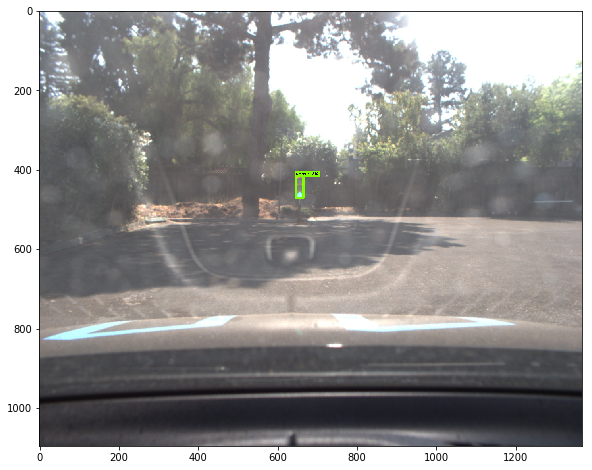

Green 0.9990958
Distance (metres) 0.0
Time in milliseconds 15.398979187011719 



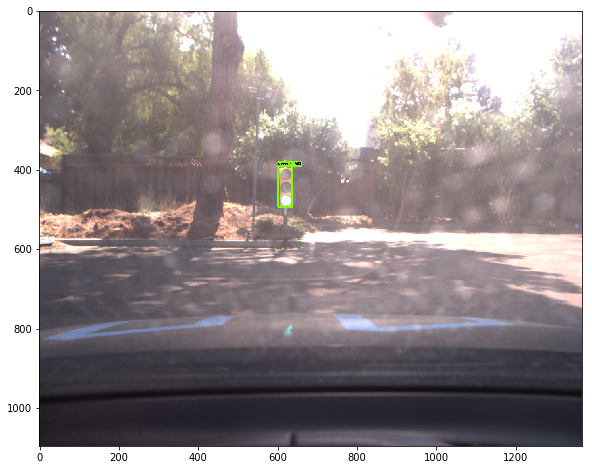

Green 0.9998412
Distance (metres) 0.0
Time in milliseconds 15.32125473022461 



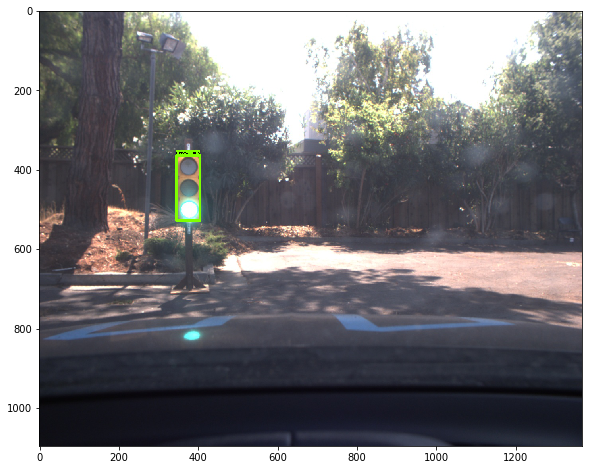

Green 0.99993765
Distance (metres) 0.0
Time in milliseconds 13.356924057006836 



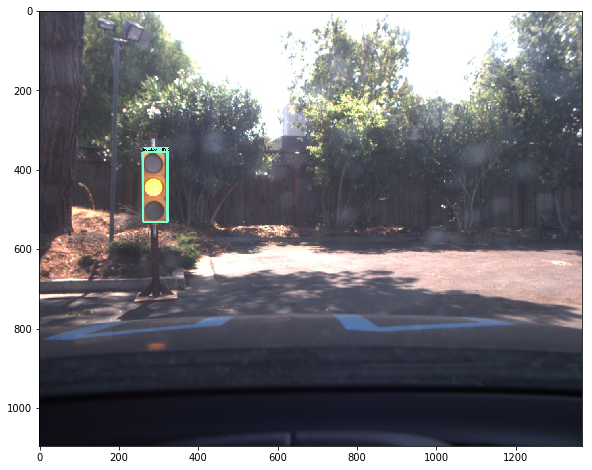

Yellow 0.6319004
Distance (metres) 0.0
Time in milliseconds 14.595508575439453 



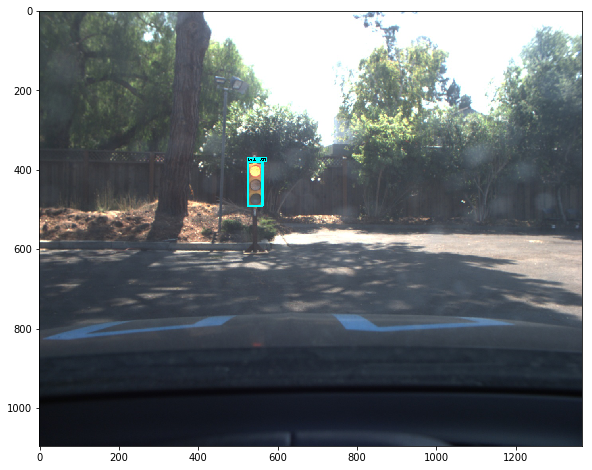

Red 0.99978036
Distance (metres) 0.0
Time in milliseconds 12.892723083496094 



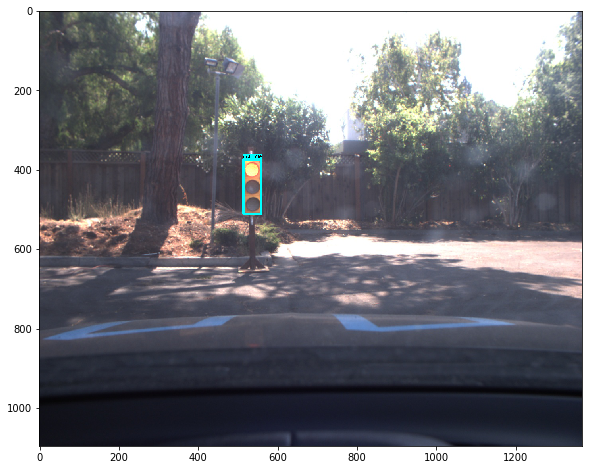

Red 0.9998246
Distance (metres) 0.0
Time in milliseconds 13.545751571655273 



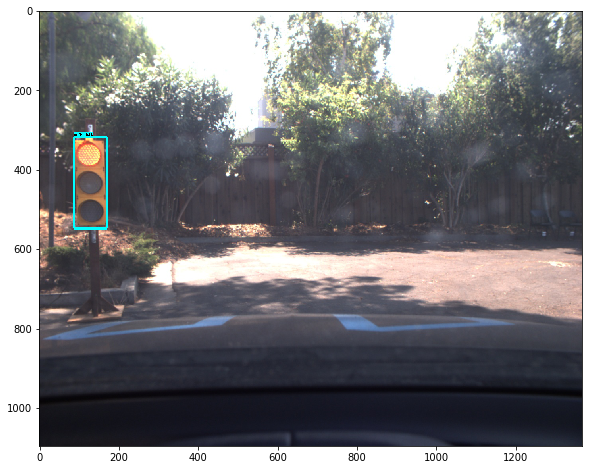

Red 0.99197716
Distance (metres) 0.0
Time in milliseconds 13.548612594604492 



In [7]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)

            time0 = time.time()

            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})

            time1 = time.time()

            boxes = np.squeeze(boxes)
            scores = np.squeeze(scores)
            classes = np.squeeze(classes).astype(np.int32)
            
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, boxes, classes, scores,
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6)
            
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()

            min_score_thresh = .50
            for i in range(boxes.shape[0]):
                if scores is None or scores[i] > min_score_thresh:

                    class_name = category_index[classes[i]]['name']
                    print('{}'.format(class_name), scores[i])
                    
                    fx =  0.97428
                    fy =  1.73205
                    perceived_width_x = (boxes[i][3] - boxes[i][1]) * 800
                    perceived_width_y = (boxes[i][2] - boxes[i][0]) * 600

                    # ymin, xmin, ymax, xmax = box
                    # depth_prime = (width_real * focal) / perceived_width
                    perceived_depth_x = ((.1 * fx) / perceived_width_x)
                    perceived_depth_y = ((.3 * fy) / perceived_width_y )

                    estimated_distance = round((perceived_depth_x + perceived_depth_y) / 2)
                    print("Distance (metres)", estimated_distance)
                    print("Time in milliseconds", (time1 - time0) * 1000, "\n")